# Definindo sistema


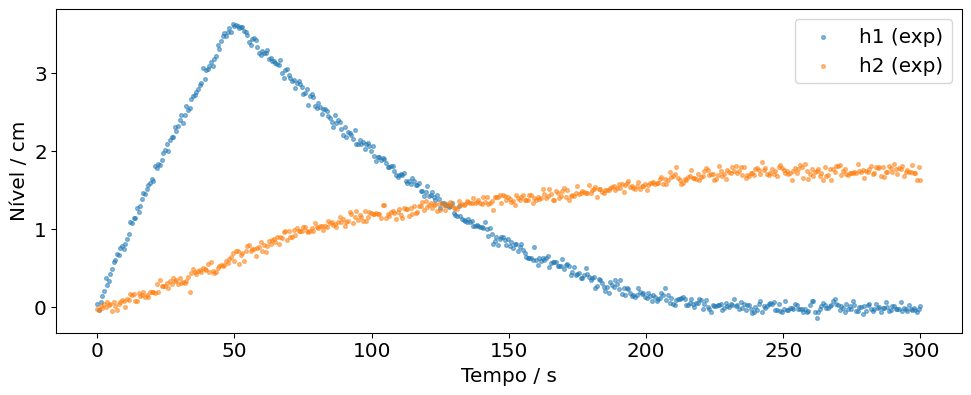

In [1]:
from typing import Any

import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

from plots import plot_tanks

# Constantes
a1 = 100  # cm^2
a2 = 100  # cm^2
cv1 = 2


def F(t, op: Any = np):
    f = op.zeros_like(t)
    f = op.where(t < 50, 10, f)
    return f


def cv2_func(t):
    cv2 = 4 - np.exp(t / 150)
    cv2 = np.where(cv2 < 0.0, 0.0, cv2)
    return cv2


def edo_np(t, Y):
    h1, h2 = Y[0], Y[1]

    # Tanks limits
    h1 = np.where(h1 < 0.0, 0.0, h1)
    h2 = np.where(h2 < 0.0, 0.0, h2)

    # Equations
    dh1dt = (F(t, np) - cv1 * np.sqrt(h1)) / a1
    dh2dt = (cv1 * np.sqrt(h1) - cv2_func(t) * np.sqrt(h2)) / a2
    return np.array([dh1dt, dh2dt])


t = np.linspace(0, 300, 500)
y0 = np.array([0, 0])

sol = solve_ivp(edo_np, [t[0], t[-1]], y0, t_eval=t)
h1_exp = sol.y[0] + np.random.normal(0, 0.05, len(t))
h2_exp = sol.y[1] + np.random.normal(0, 0.05, len(t))

plot_tanks(t, [h1_exp, h2_exp], ["h1 (exp)", "h2 (exp)"], scatter=2)

# plt.figure(figsize=(10, 4), layout="constrained")
# plt.plot(t, cv2_func(t), label="$cv_2$")
# plt.plot(t, F(t), label="F")
# plt.show()

t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(1).requires_grad_(True)


# Definindo rede neural


In [2]:
from torch import nn

torch.manual_seed(42)


class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 1  # t
        hidden_size = 32
        output_size = 3  # h1, h2, cv2

        self.hidden_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        output = self.hidden_layer(x / torch.max(t_tensor))
        return output**2


# Definindo função Loss


In [3]:
from utils import dydx, mean_square

h1_exp = torch.tensor(h1_exp, dtype=torch.float32)
h2_exp = torch.tensor(h2_exp, dtype=torch.float32)


def edo_torch(t, Y, cv2):
    h1, h2 = Y

    # Tanks limits
    h1 = torch.where(h1 < 0.0, 0.0, h1)
    h2 = torch.where(h2 < 0.0, 0.0, h2)

    # Equations
    dh1dt = (F(t, torch) - cv1 * torch.sqrt(h1)) / a1
    dh2dt = (cv1 * torch.sqrt(h1) - cv2 * torch.sqrt(h2)) / a2
    return [dh1dt, dh2dt]


def loss_fn(model, t):
    # Loss das EDOs
    Y_pred = model(t)
    h1_pred, h2_pred, cv2_pred = Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2]

    dh1dt_pinn, dh2dt_pinn = dydx(t, h1_pred), dydx(t, h2_pred)
    dh1dt_edo, dh2dt_edo = edo_torch(t, [h1_pred, h2_pred], cv2_pred)

    loss_EDO1 = mean_square(dh1dt_pinn - dh1dt_edo)
    loss_EDO2 = mean_square(dh2dt_pinn - dh2dt_edo)

    # Loss das condições iniciais
    t0 = torch.tensor([[0.0]], requires_grad=True)
    Y0 = model(t0)
    h1_0, h2_0 = Y0[:, 0], Y0[:, 1]

    loss_ic1 = mean_square(h1_0 - y0[0])
    loss_ic2 = mean_square(h2_0 - y0[1])

    # Loss dos dados
    loss_data_h1 = mean_square(h1_pred.squeeze() - h1_exp)
    loss_data_h2 = mean_square(h2_pred.squeeze() - h2_exp)

    # Loss total
    loss_total = (
        loss_EDO1 + loss_EDO2 + loss_data_h1 + loss_data_h2 + loss_ic1 + loss_ic2
    )

    return loss_total


# Testando métodos


## Adam


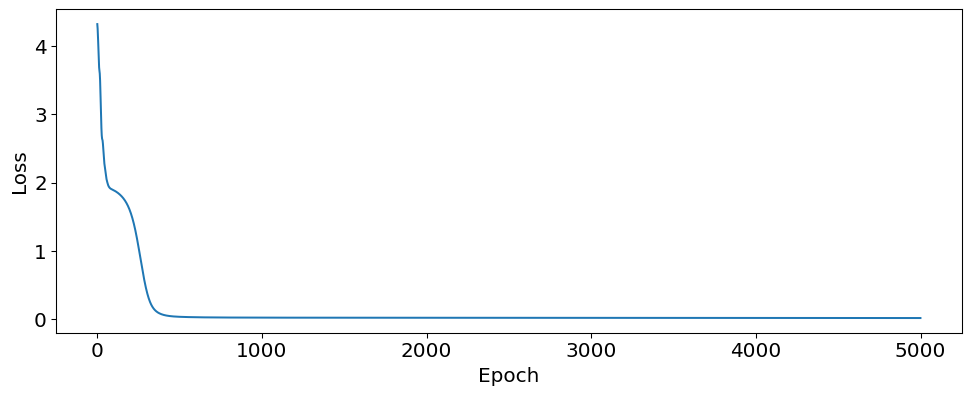

In [4]:
from plots import plot_loss

Adam_model = BaseModel()

optimizer = torch.optim.Adam(Adam_model.parameters(), lr=0.001)

# Listas vazias que usaremos para montar o gráfico do loss
loss_values = []
epoch_count = []


# O Loop de treinamento
for epoch in range(5000):
    # Coloca o modelo no modo de treinamento
    Adam_model.train()

    # Calcula o loss usando a nossa função loss.
    loss = loss_fn(Adam_model, t_tensor)

    # Ajusta os valores do modelo + detalhes de implementação do PyTorch. Não precisa se importar com isso, pelo menos por enquanto.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Guarda os valores de loss após cada época, isso vai nos ajudar a montar gráficos depois.
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())

plot_loss(loss_values, epoch_count)


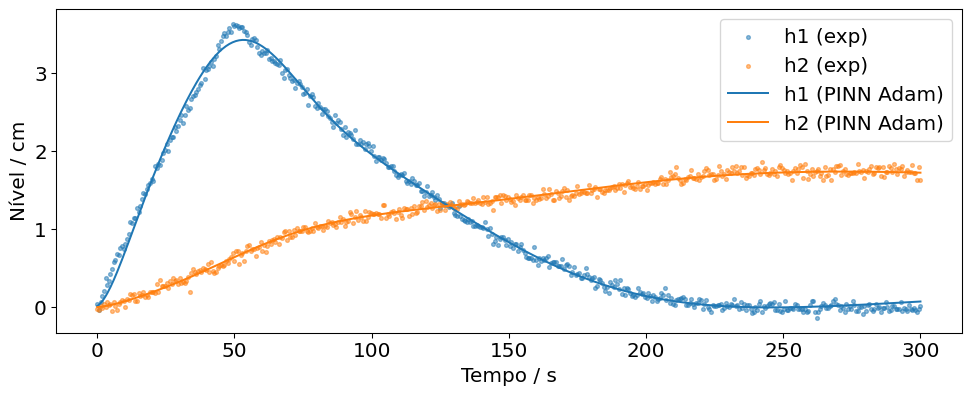

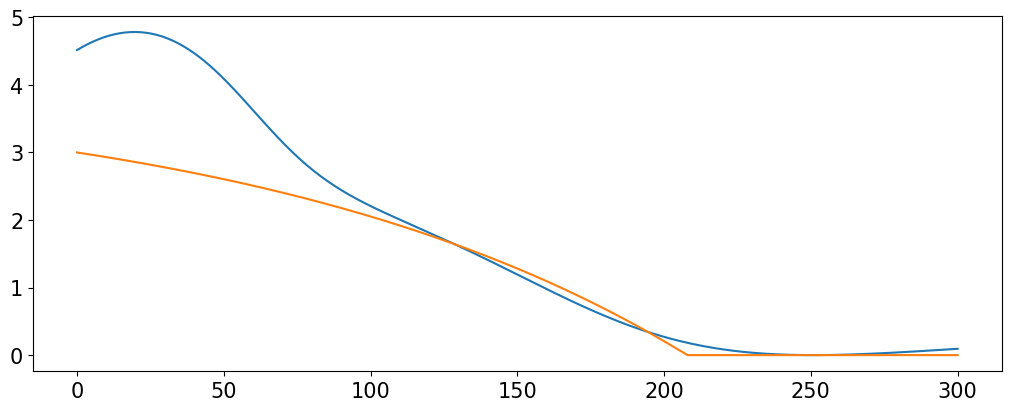

In [5]:
@torch.inference_mode()
def test_model(model):
    y = model(t_tensor)
    return [y[:, 0], y[:, 1], y[:, 2]]


pinn_h1, pinn_h2, pinn_cv2 = test_model(Adam_model)

# Gráfico
plot_tanks(
    t,
    (h1_exp, h2_exp, pinn_h1, pinn_h2),
    ["h1 (exp)", "h2 (exp)", "h1 (PINN Adam)", "h2 (PINN Adam)"],
    scatter=2,
)

plt.figure(figsize=(10, 4), layout="constrained")
plt.plot(t, pinn_cv2, label="$cv_2$ (PINN Adam)")
plt.plot(t, cv2_func(t), label="$cv_2$")
plt.show()
